Episode 9000/10000.

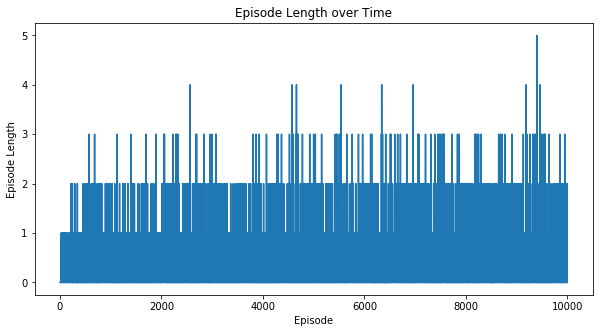

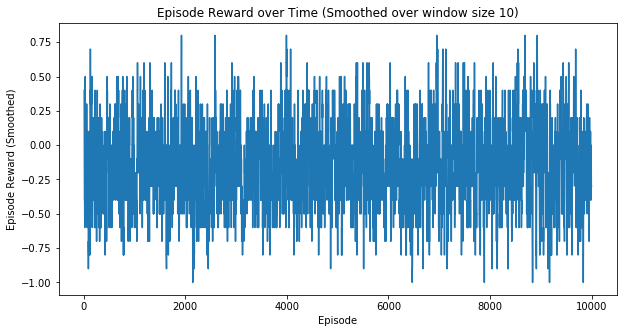

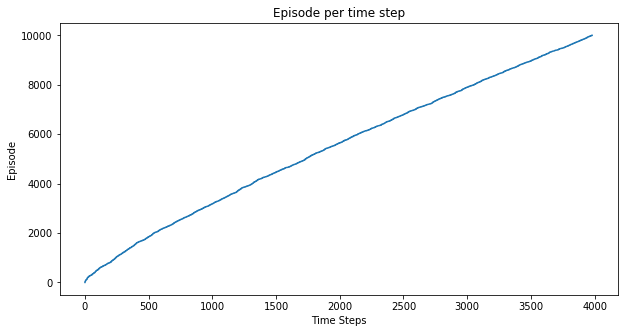

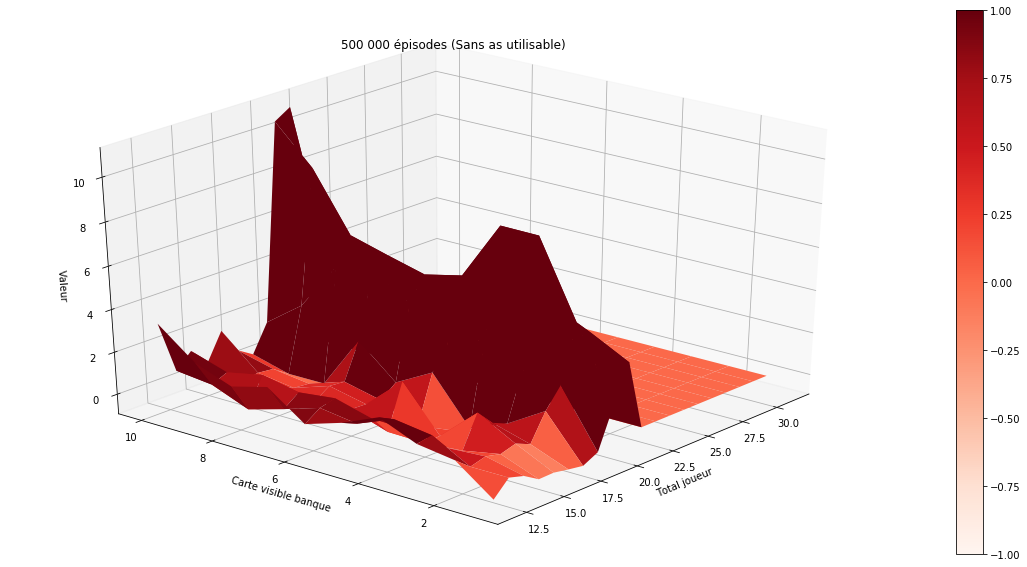

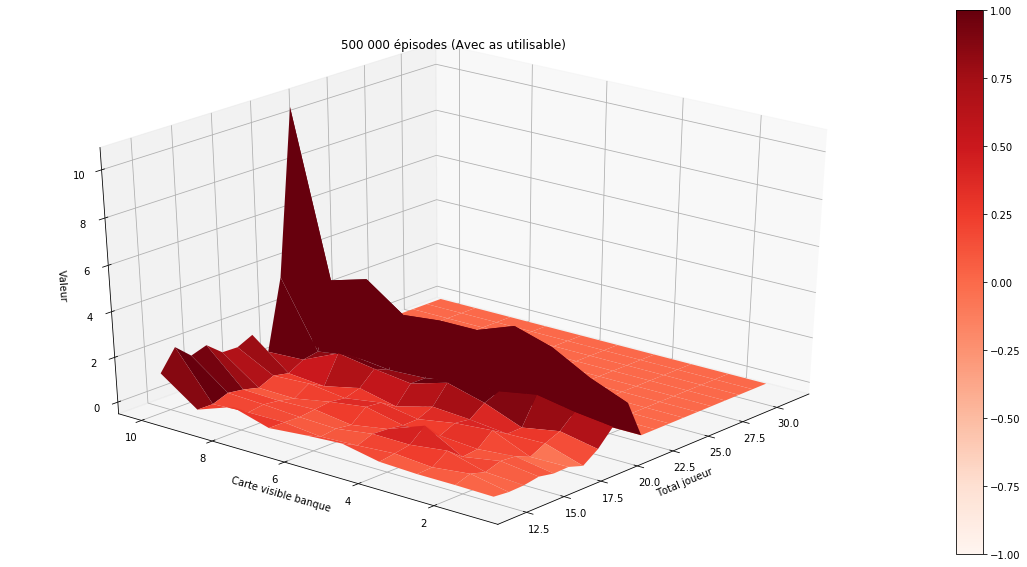

Valeur moyenne: 0.8981994110410583


In [1]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
Optimisation de politique avec méthode Monte Carlo première visite
Politique epsilon-vorace
Environnement Blackjack
"""
import gym
from gym import spaces
from gym.utils import seeding
import numpy as np
from collections import defaultdict
import itertools

def cmp(a, b):
    return int((a > b)) - int((a < b))

# 1 = As, Valet,Dame et Roi = 10
cartes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def passer_carte(np_random):
    return np_random.choice(cartes)
    
def passer_main(np_random):
    return [passer_carte(np_random), passer_carte(np_random)]

def as_utilisable(main):
    return 1 in main and sum(main) + 10 <= 21

def total_main(main):
    if as_utilisable(main):
            return sum(main) + 10
    return sum(main)

def a_creve(main):
    return total_main(main) > 21

def score(main):  # Retourne le total ou 0 si creve
    return 0 if a_creve(main) else total_main(main)

def blackjack_naturel(main):  # Un as et un dix
    return sorted(main) == [1, 10]

class BlackjackEnv(gym.Env):
    """ Environnement de Blackjack simplifié selon l'exemple 5.1 de Sutton and Barto (2020)
    Reinforcement Learning: An Introduction.
    Le code est basé sur : https://gym.openai.com/envs/Blackjack-v0/
    
    actions possibles : carter (1) ou pas (0)
    etat : 3-tuple(total joueur, la carte visible banque (1-10), as utilisable pour le joueur (vrai ou faux))
    recompense : le joueur gagne (+1), le joueur perd (-1), partie nulle (0)
    """
    def __init__(self, naturel=False,seed=42):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self._seed(seed)

        # Indicateur: paye 1.5 fois pour un naturel 
        self.naturel = naturel

        self._reset()

    def reset(self):
        return self._reset()

    def step(self, action):
        return self._step(action)

    def _seed(self, seed=42):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def _step(self, action):
        assert self.action_space.contains(action)
        if action:  # carter
            self.joueur.append(passer_carte(self.np_random))
            if a_creve(self.joueur):
                final = True
                recompense = -1
            else:
                final = False
                recompense = 0
        else:  # arrêter
            final = True
            while total_main(self.banque) < 17:
                self.banque.append(passer_carte(self.np_random))
            recompense = cmp(score(self.joueur), score(self.banque))
            if self.naturel and blackjack_naturel(self.joueur) and recompense == 1:
                recompense = 1.5
        return self._get_obs(), recompense, final, {}

    def _get_obs(self):
        return (total_main(self.joueur), self.banque[0], as_utilisable(self.joueur))

    def _reset(self):
        self.banque = passer_main(self.np_random)
        self.joueur = passer_main(self.np_random)

        # Carter si total inférieur à 12
        while total_main(self.joueur) < 12:
            self.joueur.append(passer_carte(self.np_random))
        
        return self._get_obs()

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from collections import namedtuple
import pandas as pd

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

def afficher_V(V, titre="Fonction valeur de la politique selon méthode de Monte Carlo première visite"):
    """
    Afficher V comme surface en 3D
    
    V : dictionnaire (etat, valeur)
    """
    # Déterminer les quadrillages des axes X et Y
    min_x = min(etat[0] for etat in V.keys()) # axe des x : main du joueur
    max_x = max(etat[0] for etat in V.keys())
    min_y = min(etat[1] for etat in V.keys()) # axe des y : main de la banque
    max_y = max(etat[1] for etat in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Rassembler les valeurs de z pour tous les (x, y) : distinguer les cas avec et sans as utilisable
    Z_sans_as = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_as = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def afficher_surface(X, Y, Z, titre):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surface = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.Reds, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Total joueur')
        ax.set_ylabel('Carte visible banque')
        ax.set_zlabel('Valeur')
        ax.set_title(titre)
        ax.view_init(ax.elev, -140)
        fig.colorbar(surface)
        plt.show()

    afficher_surface(X, Y, Z_sans_as, "{} (Sans as utilisable)".format(titre))
    afficher_surface(X, Y, Z_as, "{} (Avec as utilisable)".format(titre))

env = BlackjackEnv()

def contruire_politique_epsilon_vorace(Q, epsilon, nb_actions):
    """
    Creer une fonction qui calcule les probabilités d'une politique e-vorace
    
        Q: dictionnaire etat -> valeurs des actions (np.array de taille nb_actions)
        epsilon: float entre 0 et 1
        nb_actions: nombre d'actions de l'environnement
    
    Retourne une fonction qui prend un etat et retourne les probabilités d'actions e-vorace
    
    """
    def f_politique(etat):
        probabilites_actions = np.ones(nb_actions, dtype=float) * epsilon / nb_actions
        meilleure_action = np.argmax(Q[etat])
        probabilites_actions[meilleure_action] += (1.0 - epsilon)
        return probabilites_actions
    return f_politique

def politique_optimale_sarsa(env, nombre_episodes, gamma=1.0, alpha= 0.1, epsilon=0.1):
    """
    Prédire la valeur de la politique par la métode de Monte Carlo première visite

        politique: fonction pi
        env: environnement de type OpenAI gym
        nombre_episodes: nombre d'épisodes générés pour les estimations
        gamma: facteur d'escompte des récompenses futures
    
    Retour:
        V: Dictionnaire(etat,valeur)
        The etat is a tuple and the value is a float.
    """

    statistiques = EpisodeStats(episode_lengths=np.zeros(nombre_episodes),episode_rewards=np.zeros(nombre_episodes))

    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    politique = contruire_politique_epsilon_vorace(Q, epsilon, env.action_space.n)
    
    for i_episode in range(nombre_episodes):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, nombre_episodes), end="")

         # Un episode est un tableau de tules (etat, action, recompense)
            
        etat = env.reset()
        probabilites_actions = politique(etat)
        action = np.random.choice(np.arange(len(probabilites_actions)), p=probabilites_actions)
        for t in itertools.count():

            etat_suivant, recompense, final, _ = env.step(action)            
            probabilites_actions_suivant = politique(etat_suivant)
            action_suivante = np.random.choice(np.arange(len(probabilites_actions_suivant)), p=probabilites_actions_suivant)
            
            # Mettre à jour les statistiques
            statistiques.episode_rewards[i_episode] += recompense
            statistiques.episode_lengths[i_episode] = t
            
            cible = recompense+gamma*Q[etat_suivant][action_suivante]
            delta = cible-Q[etat][action]
            Q[etat][action] += alpha*delta
            
            if final:
                break
            etat = etat_suivant
            action = action_suivante
                
    return Q,statistiques


def politique_reste_20ou21(observation):
    """
    Politique simple : le joueur reste à 20 ou 21, carte sinon
    """
    return 0 if observation[0] >= 20 else 1

Q,statistiques = politique_optimale_sarsa(env, nombre_episodes=10000,gamma=1.0, alpha= 0.1, epsilon=0.1)
plot_episode_stats(statistiques)

# Calculer et afficher la valeur de V calculée à partir de Q
V = defaultdict(float)
somme=0
nb=0
for etat, actions in Q.items():
    V[etat] = np.max(actions)
    somme+=V[etat]
    nb+=1
    
afficher_V(V, titre="500 000 épisodes")
print("Valeur moyenne:", somme/nb)